# 시계열 모델링_따릉이

* 지금까지 배운 것을 복습 합니다.
* Data : 서울 공유 자전거
* 문제 : 2시간 후의 수요를 예측하고자 합니다.
* 최소 2개 이상의 모델을 만들고 성능을 비교해 봅시다.
------

![](https://mediahub.seoul.go.kr/uploads/mediahub/2021/03/RaKqiqgRXyNmYVYymXQIvCjPHpncuhBX.png)

## 1.환경준비

### (1) 라이브러리 로딩

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, Flatten, SimpleRNN, LSTM, Flatten, Input
from keras.backend import clear_session
from keras.optimizers import Adam

### (2) 필요한 함수 생성

* 학습곡선 함수

In [16]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

* 데이터 2 --> 3차원 변환

In [17]:
# 시계열 데이터 전처리 2차원 --> 3차원으로 변환
def temporalize(x, y, timesteps):
    nfeature = x.shape[1]
    output_x = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        t = []
        for j in range(timesteps):
            t.append(x[[(i + j)], :])
        output_x.append(t)
        output_y.append(y[i + timesteps - 1])
    return np.array(output_x).reshape(-1,timesteps, nfeature), np.array(output_y)

### (3) 데이터로딩

In [18]:
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/SeoulBikeData2.csv'
data = pd.read_csv(path)
data.drop(['Visibility','Solar'], axis = 1, inplace = True)
data['DateTime'] = pd.to_datetime(data['DateTime'], format='%Y-%m-%d %H:%M:%S')
data.head()

,DateTime,Count,Temperature,Humidity,WindSpeed,Rainfall,Snowfall,Seasons,Holiday,FuncDay
0,2017-12-01 00:00:00,254,-5.2,37,2.2,0.0,0.0,Winter,No Holiday,Yes
1,2017-12-01 01:00:00,204,-5.5,38,0.8,0.0,0.0,Winter,No Holiday,Yes
2,2017-12-01 02:00:00,173,-6.0,39,1.0,0.0,0.0,Winter,No Holiday,Yes
3,2017-12-01 03:00:00,107,-6.2,40,0.9,0.0,0.0,Winter,No Holiday,Yes
4,2017-12-01 04:00:00,78,-6.0,36,2.3,0.0,0.0,Winter,No Holiday,Yes


**변수설명**  

* DateTime : year-month-day hh:mi:ss
* Count : 시간대별 수요량
* Temperature : 온도(섭씨)
* Humidity : 습도(%)
* WindSpeed : 풍속(m/s)
* Rainfall - mm
* Snowfall - cm
* Seasons - Winter, Spring, Summer, Autumn
* Holiday - Holiday / No holiday
* FuncDay - Yes / No


In [19]:
# 데이터 기간은 다음과 같습니다.
data.DateTime.min(), data.DateTime.max()

(Timestamp('2017-12-01 00:00:00'), Timestamp('2018-11-30 23:00:00'))

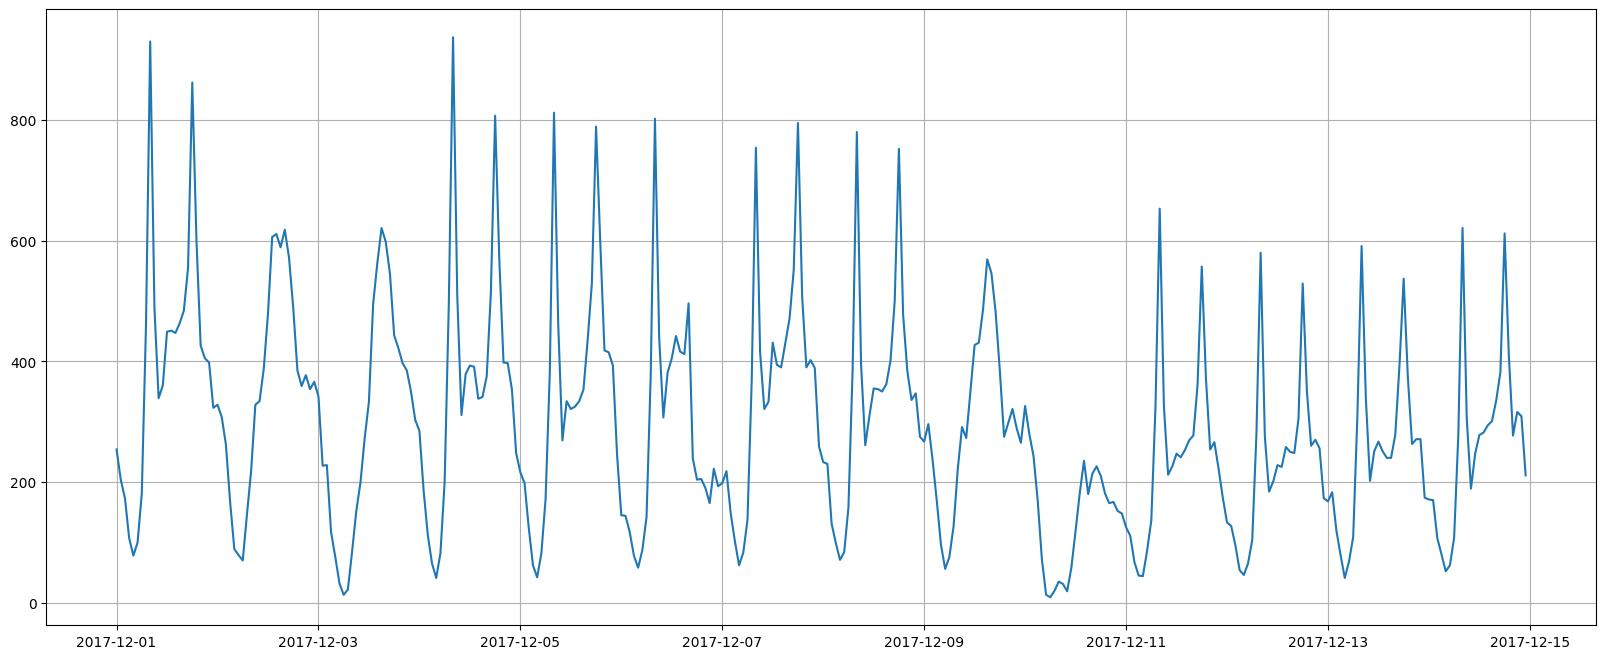

In [20]:
# 14일 동안의 수요량을 살펴 봅시다.
temp = data[:24*14]
plt.figure(figsize = (20,8))
plt.plot('DateTime', 'Count', data = temp)
plt.grid()
plt.show()

## 2.데이터 준비

### (1) y 만들기
* 2시간 이후의 수요량을 예측해야 합니다.

In [21]:
data['y'] = data['Count'].shift(-2)
data.head()

,DateTime,Count,Temperature,Humidity,WindSpeed,Rainfall,Snowfall,Seasons,Holiday,FuncDay,y
0,2017-12-01 00:00:00,254,-5.2,37,2.2,0.0,0.0,Winter,No Holiday,Yes,173.0
1,2017-12-01 01:00:00,204,-5.5,38,0.8,0.0,0.0,Winter,No Holiday,Yes,107.0
2,2017-12-01 02:00:00,173,-6.0,39,1.0,0.0,0.0,Winter,No Holiday,Yes,78.0
3,2017-12-01 03:00:00,107,-6.2,40,0.9,0.0,0.0,Winter,No Holiday,Yes,100.0
4,2017-12-01 04:00:00,78,-6.0,36,2.3,0.0,0.0,Winter,No Holiday,Yes,181.0


In [22]:
# 2칸을 앞당겼기 때문에 하위 2행의 y값에 NaN이 표시되어 있습니다.
data.tail()

,DateTime,Count,Temperature,Humidity,WindSpeed,Rainfall,Snowfall,Seasons,Holiday,FuncDay,y
8755,2018-11-30 19:00:00,1003,4.2,34,2.6,0.0,0.0,Autumn,No Holiday,Yes,694.0
8756,2018-11-30 20:00:00,764,3.4,37,2.3,0.0,0.0,Autumn,No Holiday,Yes,712.0
8757,2018-11-30 21:00:00,694,2.6,39,0.3,0.0,0.0,Autumn,No Holiday,Yes,584.0
8758,2018-11-30 22:00:00,712,2.1,41,1.0,0.0,0.0,Autumn,No Holiday,Yes,NaN
8759,2018-11-30 23:00:00,584,1.9,43,1.3,0.0,0.0,Autumn,No Holiday,Yes,NaN


In [23]:
# 하위 2행은 삭제합니다.
# 하위 2행 제외하고 다시 붓기
data = data[:-2]

### (2) Feature Engineering

In [24]:
# 요일
data['WeekDay'] = data['DateTime'].dt.dayofweek

# 주말여부
data['WeekEnd'] = np.where(data['WeekDay']>4, 1,0)

# hour
data['Hour'] = data['DateTime'].dt.hour
data.head()

<ipython-input-24-7db56336ddf0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['WeekDay'] = data['DateTime'].dt.dayofweek
<ipython-input-24-7db56336ddf0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['WeekEnd'] = np.where(data['WeekDay']>4, 1,0)
<ipython-input-24-7db56336ddf0>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

,DateTime,Count,Temperature,Humidity,WindSpeed,Rainfall,Snowfall,Seasons,Holiday,FuncDay,y,WeekDay,WeekEnd,Hour
0,2017-12-01 00:00:00,254,-5.2,37,2.2,0.0,0.0,Winter,No Holiday,Yes,173.0,4,0,0
1,2017-12-01 01:00:00,204,-5.5,38,0.8,0.0,0.0,Winter,No Holiday,Yes,107.0,4,0,1
2,2017-12-01 02:00:00,173,-6.0,39,1.0,0.0,0.0,Winter,No Holiday,Yes,78.0,4,0,2
3,2017-12-01 03:00:00,107,-6.2,40,0.9,0.0,0.0,Winter,No Holiday,Yes,100.0,4,0,3
4,2017-12-01 04:00:00,78,-6.0,36,2.3,0.0,0.0,Winter,No Holiday,Yes,181.0,4,0,4


### (3) x, y 분리

In [25]:
target = 'y'
x = data.drop(['DateTime', target], axis = 1)
y = data.loc[:,target]

### (4) 가변수화

In [26]:
cat_cols = ['Seasons','Holiday','FuncDay', 'WeekDay','Hour']
x = pd.get_dummies(x, columns = cat_cols, drop_first = True)

### (5) 스케일링

* y 값이 클때는 y도 스케일링 필요

In [27]:
# x 스케일링
scaler_x = MinMaxScaler()
x_s = scaler_x.fit_transform(x)

In [28]:
# y는 1차원이므로 수동으로.
y_max, y_min = y.max(), y.min()
y_s = (y - y_min) / (y_max - y_min)

### (6) 3차원 구조 만들기

In [30]:
timestep = 24   # 하루치 온전히 24, 일주일 7*24⬅️ 수정
x2, y2 = temporalize(x_s, y_s, timestep)
x2.shape, y2.shape

((8735, 24, 41), (8735,))

### (7) 데이터 분할

In [31]:
x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size= 24*14, shuffle = False)

In [32]:
x_train.shape, y_train.shape

((8399, 24, 41), (8399,))

In [33]:
x_val.shape, y_val.shape

((336, 24, 41), (336,))

## 3.모델링1



### (1) 입력 구조(shape)
* 분석 단위 : 2차원 ( timesteps, nfeatures)

In [34]:
timesteps=x_train.shape[1]
n=x_train.shape[2]

### (2) 모델 구조 설계

In [36]:
clear_session()

model1 = Sequential([Input(shape=(timesteps,n )),
                     LSTM( 30 ,return_sequences='True'),
                     LSTM( 20, return_sequences='True'),
                     LSTM( 10, return_sequences='False'),
                     Flatten(),
                     Dense(30, activation='relu'),
                     Dense(20, activation='relu'),
                     Dense(10, activation='relu'),
                     Dense(1)])

model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 24, 30)              │           8,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 24, 20)              │           4,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 24, 10)              │           1,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 240)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 30)                  │           7,230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 20)                  │             620 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 10)                  │             210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,031 (86.06 KB)

 Trainable params: 22,031 (86.06 KB)

 Non-trainable params: 0 (0.00 B)

### (3) 컴파일 및 학습

In [38]:
model1.compile(optimizer=Adam(learning_rate=0.01),loss='mse')

In [40]:
hist=model1.fit(x_train,y_train,epochs=20,verbose=0,validation_split=0.2).history

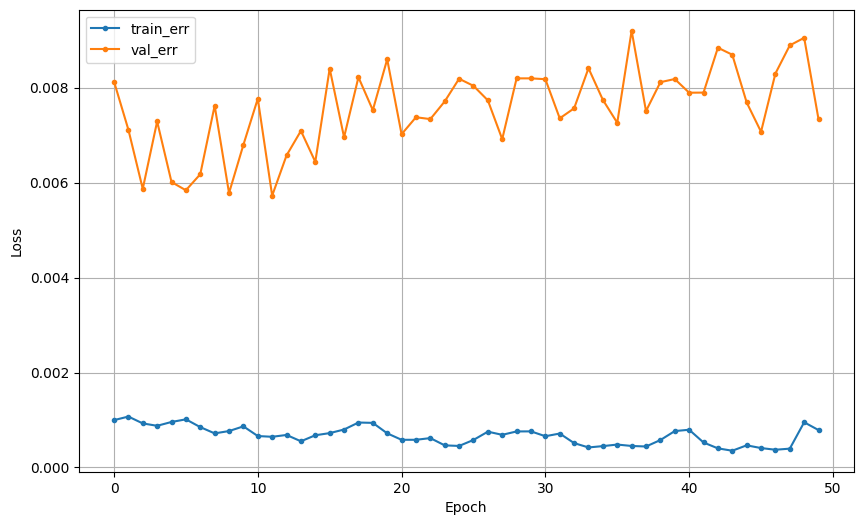

In [48]:
dl_history_plot(hist)

### (4) 예측 및 평가

In [41]:
# 예측
pred1 = model1.predict(x_val)

# y를 원래대로 돌려 놓기
y_val_real = y_val * (y_max - y_min) + y_min
pred_real  = pred1 * (y_max - y_min) + y_min

mean_absolute_error(y_val_real, pred_real)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


156.80199584152018

In [ ]:
# 위의 156의 의미는? 따릉이 대여량 예측, 156대 정도 차이가 난다. 너무 차이 많이 나는거 아냐?

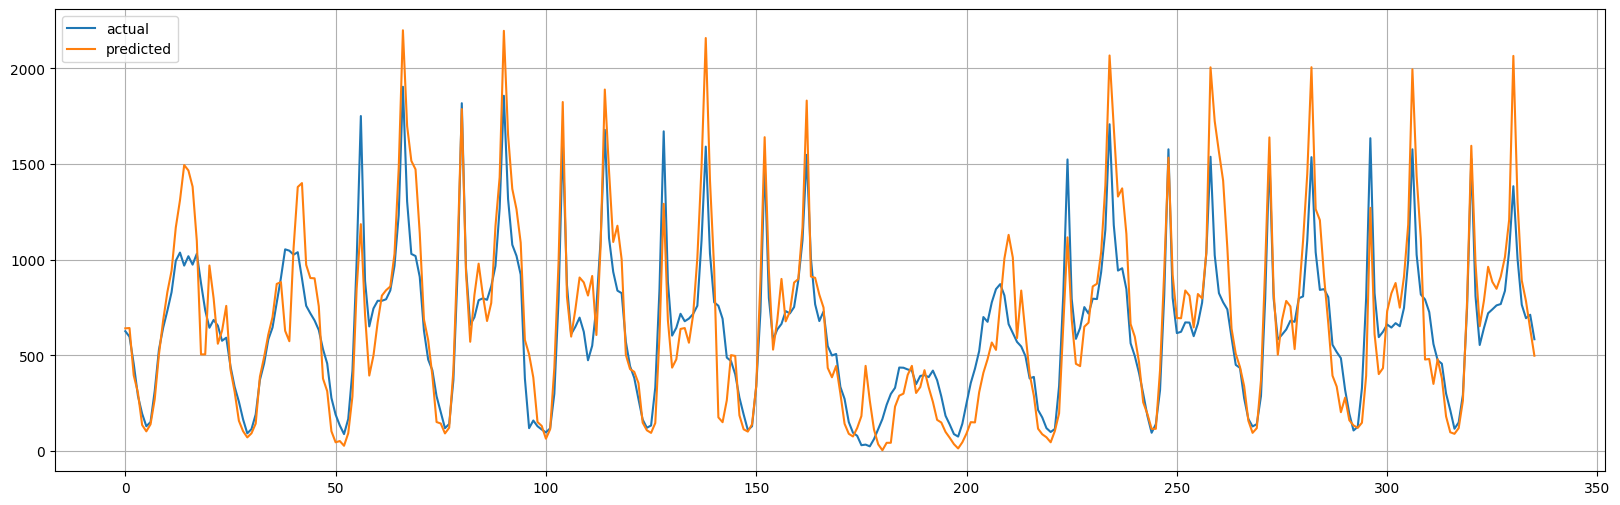

In [42]:
plt.figure(figsize = (20,6))
plt.plot(y_val_real, label = 'actual')
plt.plot(pred_real, label = 'predicted')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# 결과를 보면 평균 1000대 정도 사용량을 보여주고 있음

## 4.모델링2



### (1) 입력 구조(shape)
* 분석 단위 : 2차원 ( timesteps, nfeatures)

In [43]:
timesteps= x_train.shape[1]
n=x_train.shape[2]

### (2) 모델 구조 설계

In [44]:
clear_session()
model2=Sequential([Input(shape=(timesteps,n)),
                   LSTM(25, return_sequences='True'),
                   LSTM(10,return_sequences='False'),
                   Flatten(),
                   Dense(25,activation='relu'),
                   Dense(10,activation='relu'),
                   Dense(1)])

model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 24, 25)              │           6,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 24, 10)              │           1,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 240)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           6,025 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,436 (56.39 KB)

 Trainable params: 14,436 (56.39 KB)

 Non-trainable params: 0 (0.00 B)

### (3) 컴파일 및 학습

In [45]:
model2.compile(optimizer=Adam(learning_rate=0.01),loss='mse')

In [47]:
hist=model2.fit(x_train,y_train,epochs=50,verbose=0,validation_split=0.2).history

In [ ]:
dl_history_plot(hist)

### (4) 예측 및 평가

In [ ]:
# 예측
pred1 = model1.predict(x_val)

# y를 원래대로 돌려 놓기
y_val_real = y_val * (y_max - y_min) + y_min
pred_real  = pred1 * (y_max - y_min) + y_min

mean_absolute_error(y_val_real, pred_real)

In [ ]:
plt.figure(figsize = (20,6))
plt.plot(y_val_real, label = 'actual')
plt.plot(pred_real, label = 'predicted')
plt.legend()
plt.grid()
plt.show()